<a href="https://colab.research.google.com/github/pat-ch0/DataScience-intro/blob/main/Cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chargement du jeu de données Boston Housing

Prédire le prix médian des maisons dans une banlieue donnée de Boston au milieu des années 1970, en fonction de données concernant cette banlieue à l'époque, telles que le taux de criminalité, le taux d'imposition foncière local, etc.

Le jeu de données que vous utiliserez présente une différence intéressante par rapport aux deux exemples précédents.

Il comporte relativement peu de points de données : seulement 506, répartis entre 404 échantillons d'entraînement et 102 échantillons de test. Et chaque caractéristique des données d'entrée (par exemple, le taux de criminalité) a une échelle différente. Par exemple, certaines valeurs sont des proportions, qui prennent des valeurs entre 0 et 1 ; d'autres prennent des valeurs entre 1 et 12, d'autres entre 0 et 100, etc.

In [ ]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = \
boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train a small dense network on the Boston Housing data

## Encode the data

### Preparing the data

Il serait problématique de fournir à un réseau de neurones des valeurs qui ont toutes des plages très différentes.

Le réseau pourrait être capable de s'adapter automatiquement à des données aussi hétérogènes, mais cela rendrait certainement l'apprentissage plus difficile.

Une pratique courante pour traiter ce type de données est d'effectuer une normalisation par caractéristique : pour chaque caractéristique des données d'entrée (une colonne dans la matrice de données d'entrée), on soustrait la moyenne de la caractéristique et on divise par l'écart type, de sorte que la caractéristique soit centrée autour de 0 et ait un écart type unitaire. Cela se fait facilement avec Numpy.



#### Preparing the data 1.1

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Cette section du code est axée sur le **prétraitement des données**, plus précisément sur une technique appelée **mise à l'échelle des caractéristiques** ou **standardisation**. L'objectif est de transformer les données d'entrée (`train_data` et `test_data`) afin que chaque caractéristique (colonne) ait une moyenne de 0 et un écart type de 1. Cela est fait pour garantir que les caractéristiques avec des échelles différentes n'influencent pas de manière disproportionnée le processus d'apprentissage du modèle.
* `axis=0` spécifie que la moyenne doit être calculée le long des colonnes.
*  `train_data -= mean` soustrait la `mean` calculée de chaque caractéristique correspondante dans `train_data`, centrant ainsi efficacement les données autour de 0.
*  `std = train_data.std(axis=0)` calcule l'écart type de chaque caractéristique dans train_data (après centrage) et le stocke dans la variable std.

Ces lignes appliquent la même mise à l'échelle (en utilisant la mean et le std calculés à partir des données d'entraînement) aux test_data. Ceci est crucial pour garantir que les données de test sont prétraitées de la même manière que les données d'entraînement.

En résumé, ce code standardise les caractéristiques des données d'entraînement et de test afin d'améliorer les performances et la stabilité du modèle d'apprentissage automatique. En appliquant ces transformations, le modèle peut plus facilement apprendre des schémas à partir des données, quelles que soient les échelles d'origine des caractéristiques.

### Building your network

Parce que si peu d'échantillons sont disponibles, vous utiliserez un très petit réseau avec deux couches cachées, chacune comportant 64 unités.

En général, moins vous avez de données d'entraînement, plus le surapprentissage sera important, et l'utilisation d'un petit réseau est un moyen d'atténuer le surapprentissage.

In [ ]:
from keras import models
from keras import layers

In [ ]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', \
                         input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

*  `optimizer='rmsprop'` : L'optimiseur 'rmsprop' est utilisé pour ajuster les poids du modèle pendant l'entraînement. Il s'agit d'un algorithme qui tente de trouver les meilleurs poids pour minimiser la fonction de perte.
*  `loss='mse'` : La fonction de perte utilisée est l'erreur quadratique moyenne ("Mean Squared Error", MSE). Elle mesure la différence entre les prédictions du modèle et les valeurs réelles. L'objectif de l'entraînement est de minimiser cette perte.
*  `metrics=['mae']` : On souhaite surveiller l'erreur absolue moyenne ("Mean Absolute Error", MAE) pendant l'entraînement. C'est une autre mesure de la performance du modèle.

### 3-fold cross-validation

In [ ]:
import numpy as np

#### 3-fold cross-validation 1.1

In [ ]:
num_epochs = 100
all_scores = []

k = 4 # Setting k to 4 for 4-fold cross-validation
num_val_samples = len(train_data) // k # Calculate the size of each validation set

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data =\
  np.concatenate([train_data[:i * num_val_samples], \
                  train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = \
  np.concatenate([train_targets[:i * num_val_samples],\
                  train_targets[(i + 1) * num_val_samples:]], axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, \
            epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3


Ce code effectue une validation croisée k-fold en divisant à plusieurs reprises les données d'entraînement en ensembles d'entraînement et de validation, en entraînant un modèle sur l'ensemble d'entraînement et en l'évaluant sur l'ensemble de validation. Les scores de validation sont collectés pour chaque pli, fournissant une estimation plus fiable des performances du modèle sur des données non vues. En calculant la moyenne des scores de tous les plis, on obtient une mesure de performance plus robuste que si l'on évaluait simplement le modèle sur une seule division train/test.

*  `all_scores = []` initialise une liste vide pour stocker les scores de validation (erreur absolue moyenne - MAE dans ce cas) pour chaque pli (fold).
* `partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)` crée les données d'entraînement pour le pli courant en concaténant deux parties de train_data : les données avant le jeu de validation et les données après. Cela garantit que le jeu de validation n'est pas utilisé pour l'entraînement.
*  `model = build_model()` appelle la fonction `build_model` (définie plus haut dans le code) pour créer une nouvelle instance du modèle de réseau neuronal.
*  `val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)` évalue le modèle entraîné sur les données de validation (`val_data` et `val_targets`) et renvoie l'erreur quadratique moyenne (`val_mse`) et l'erreur absolue moyenne (`val_mae`). `verbose=0` supprime la sortie d'évaluation.

In [ ]:
num_epochs_1 = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data_1 = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets_1 = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data_1 = \
  np.concatenate([train_data[:i * num_val_samples],\
                  train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets_1 = \
  np.concatenate([train_targets[:i * num_val_samples],\
                  train_targets[(i + 1) * num_val_samples:]], axis=0)
  model_1 = build_model()
  history_1 = model.fit(partial_train_data_1, partial_train_targets_1,\
                        validation_data=(val_data_1, val_targets_1),\
                        epochs=num_epochs, batch_size=1, verbose=0)
  mae_history = history_1.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


processing fold # 1
processing fold # 2
processing fold # 3


In [ ]:
average_mae_history = [\
                       np.mean([x[i] for x in all_mae_histories]) for i in \
                       range(num_epochs)]

In [ ]:
import matplotlib.pyplot as plt

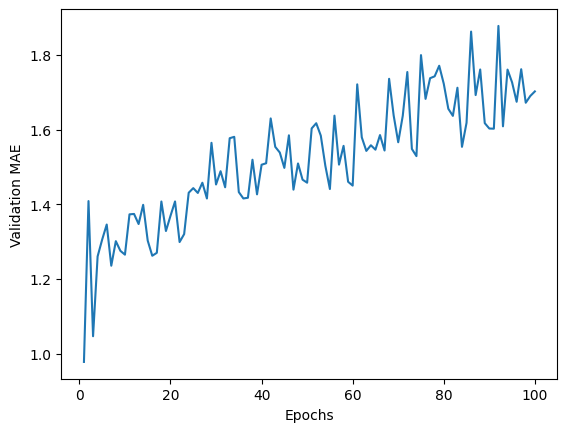

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1),\
               average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Une fois que vous avez terminé d'ajuster les autres paramètres du modèle (en plus du nombre d'epochs, vous pourriez également ajuster la taille des couches cachées), vous pouvez entraîner un modèle final de production sur toutes les données d'entraînement, avec les meilleurs paramètres, puis observer ses performances sur les données de test.

In [ ]:
model_2 = build_model()

model_2.fit(train_data, train_targets,\
            epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.9163 - mae: 2.4157


## Questions

**Quel est l'objectif de ce notebook ?**

Prédire le prix médian des maisons dans une banlieue donnée de Boston au milieu des années 1970, en se basant sur des données concernant cette banlieue à l'époque, telles que le taux de criminalité, le taux d'imposition foncière local, etc.

**Pourquoi est-il important de prétraiter les données avant de les utiliser pour entraîner un modèle d'apprentissage automatique ?**

Le prétraitement, notamment la mise à l'échelle des caractéristiques, est crucial car il permet d'uniformiser les échelles des différentes caractéristiques des données. Cela facilite l'apprentissage du modèle en évitant que les caractéristiques avec des valeurs plus grandes n'influencent de manière disproportionnée le processus d'apprentissage.

**Qu'est-ce que la validation croisée et pourquoi est-elle utilisée dans ce notebook ?**

La validation croisée est une technique qui consiste à diviser les données d'entraînement en plusieurs parties (plis) et à entraîner le modèle sur une partie tout en le validant sur une autre. Cela permet d'obtenir une estimation plus fiable des performances du modèle sur des données non vues et d'éviter le surapprentissage.

**Comment le surapprentissage est-il anticipé dans ce notebook ?**

Le surapprentissage est abordé en utilisant un réseau neuronal relativement petit avec seulement deux couches cachées. Un réseau plus petit est moins susceptible de mémoriser les données d'entraînement et a donc plus de chances de généraliser correctement à de nouvelles données.

**Expliquez le rôle de la fonction `build_model()` dans ce code.**

La fonction build_model() est responsable de la création et de la configuration du modèle de réseau neuronal. Elle définit l'architecture du modèle, y compris le nombre de couches, le nombre d'unités par couche, les fonctions d'activation, l'optimiseur, la fonction de perte et les métriques à suivre.

**Que signifient les paramètres `epochs` et `batch_size` dans la fonction model_2.fit() ?**

- `epochs` : nombre de fois où le modèle parcourt l'ensemble des données d'entraînement pendant l'apprentissage.

- `batch_size` : nombre d'échantillons de données utilisés à chaque itération de la mise à jour des poids du modèle.

**À quoi servent les variables `test_mse_score` et `test_mae_score` ?**

Ces variables stockent les résultats de l'évaluation du modèle sur les données de test. `test_mse_score` représente l'erreur quadratique moyenne (Mean Squared Error) et `test_mae_score` représente l'erreur absolue moyenne (Mean Absolute Error), qui sont des mesures de la performance du modèle.

**Pourquoi est-il important d'évaluer le modèle sur des données de test distinctes des données d'entraînement ?**

Il est crucial d'évaluer le modèle sur des données de test distinctes pour vérifier sa capacité à généraliser à de nouvelles données qu'il n'a jamais vues pendant l'entraînement. Cela permet de s'assurer que le modèle n'a pas simplement mémorisé les données d'entraînement mais qu'il a réellement appris des schémas généraux.

**Que se passerait-il si on utilisait model au lieu de model_2 pour évaluer le modèle dans la dernière ligne?**

Si on utilisait model au lieu de model_2 dans la dernière ligne, on évaluerait un modèle potentiellement non optimal. model fait référence à une instance de modèle créée et entrainée lors de la validation croisée, tandis que model_2 est le modèle final entrainé sur toutes les données d'entrainement.

**Comment pourriez-vous améliorer encore les performances de ce modèle ?**

Le modèle est limité par les données sur lesquelles il a été entraîné. Si les données d'entraînement ne sont pas représentatives de la réalité, le modèle peut faire des prédictions erronées. De plus, le modèle peut être sujet à des biais présents dans les données d'entraînement. Il est important de garder ces limitations à l'esprit lors de l'interprétation des résultats.